# Loading Library and Data

In [12]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
import os
import glob

def get_files(fn):
    home = os.path.expanduser('~')
    path = f'{home}/Downloads/project_mining_2022/dataset/'
    files = glob.glob(path + fn + '/*.csv')
    return files


def to_date(char):
    return char[:4] + '-' + char[4:6] + '-' + char[6:8]

# for each file create a pandas df
# concatenate them all together
# change index to datetime
def parse_file(files, filenames):
    list_of_pandas = []
    for i, f in enumerate(files):
        # if file empty
        if os.stat(f).st_size != 0:
            # create df
            temp = pd.read_csv(f, header=0, nrows=288, skip_blank_lines=False)
            # create date column
            temp['Date'] = [to_date(filenames[i]) for _ in range(288)]
            # append df 
            list_of_pandas += [temp]
    # cast all together
    df = pd.concat(list_of_pandas, ignore_index=True)
    df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    df.drop(columns=['Date', 'Time'], inplace=True)
    return df

In [13]:
# list files
demand_files = get_files('demand')
source_files = get_files('sources')

# list filenames to use on timestamps
filenames = [file[-12: -4] for file in demand_files]

# get data from files
demands = parse_file(demand_files, filenames)
sources = parse_file(source_files, filenames)

# Preprocessing Data

## Transfering new columns values to old

In [14]:
# move values and drop temp cols
sources['Natural gas'].fillna(sources['Natural Gas'], inplace=True)
sources['Large hydro'].fillna(sources['Large Hydro'], inplace=True)
sources.drop(columns=['Natural Gas', 'Large Hydro'], inplace=True)

## Handling Missing values

In [15]:
demands.isna().sum()

Day ahead forecast     48
Hour ahead forecast    24
Current demand         52
dtype: int64

In [16]:
sources.isna().sum()

Solar           54
Wind            54
Geothermal     342
Biomass         54
Biogas          54
Small hydro     54
Coal            54
Nuclear         54
Natural gas    342
Large hydro     54
Batteries       54
Imports        342
Other           54
dtype: int64

In [17]:
# null values in demands are probably due to power cut
# so, linear interpolation will be good estimate
demands.interpolate(method='linear', axis=0, inplace=True)

In [18]:
# Linear interpolatio for missing data
sources.interpolate(method='linear', axis=0, inplace=True)

# Data Visualization

## Visualize whole dataset

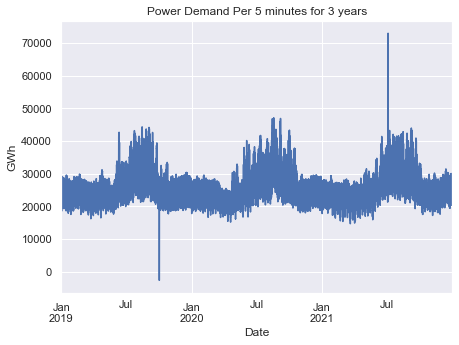

In [19]:
# plot all data with respect to time
plt.rcParams['figure.figsize'] = [7, 5]
demands['Current demand'].plot(xlabel='Date', ylabel='GWh', title = 'Power Demand Per 5 minutes for 3 years')
plt.show()

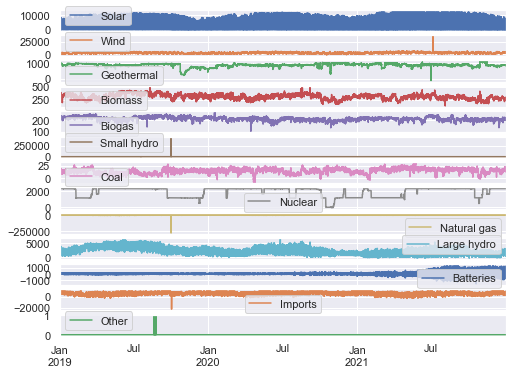

In [9]:
plt.rcParams['figure.figsize'] = [8, 6]
sources.plot(subplots=True)
plt.show()

In [20]:
renewable = ['Solar', 'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Small hydro',  'Large hydro', 'Batteries', 'Imports']
non_renewable = ['Coal', 'Nuclear', 'Natural gas']

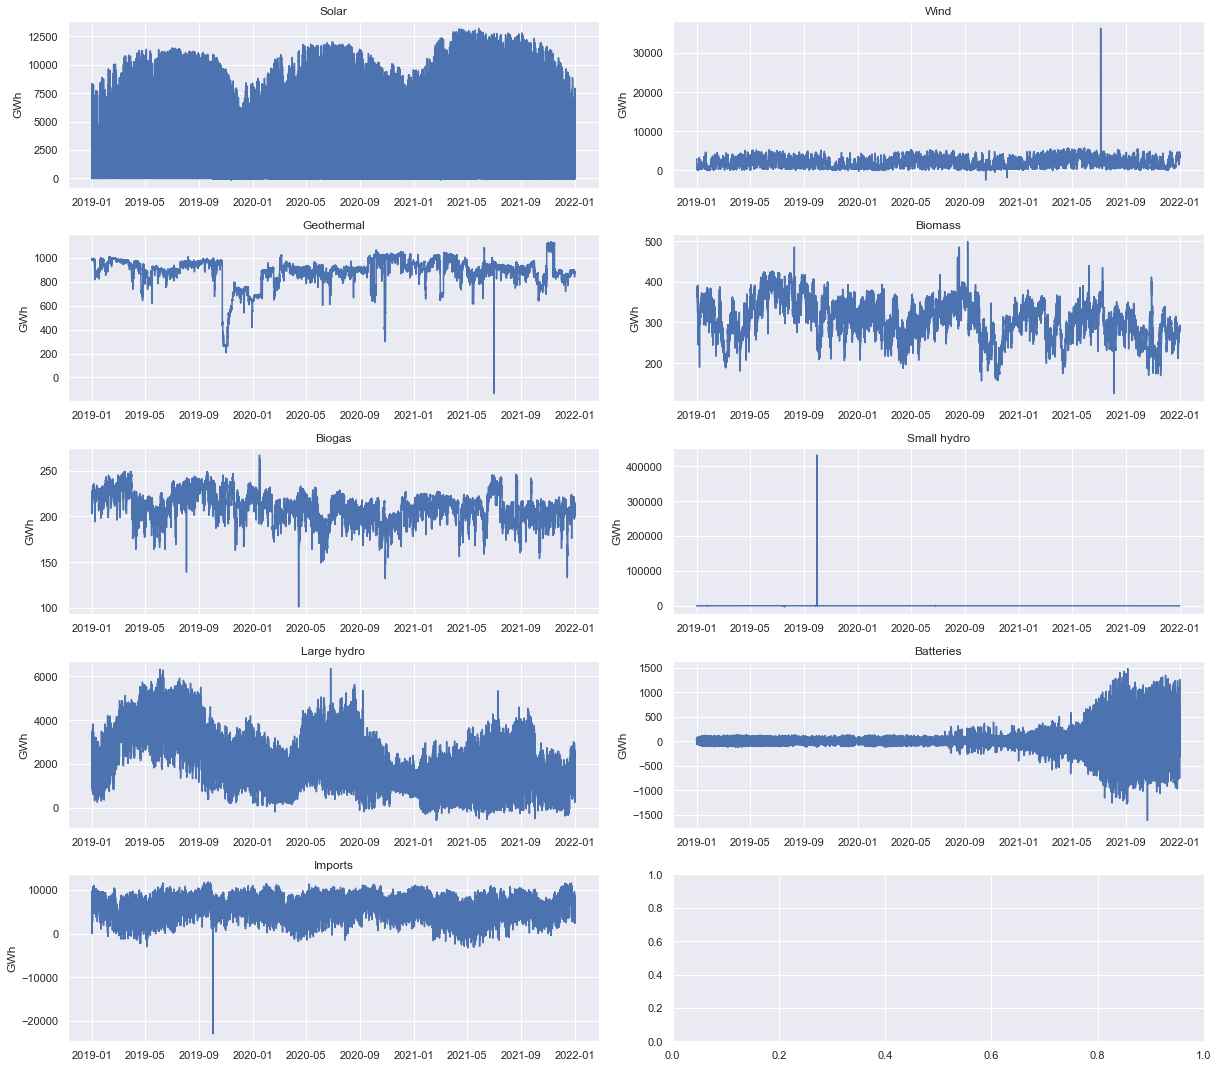

In [21]:
fig, axs = plt.subplots(5, 2, figsize=(17, 15))
try:
    for i in range(5):
        for j in range(2):
            axs[i, j].plot(sources[renewable[2*i+j]])
            axs[i, j].set_title(renewable[2*i+j])
            axs[i, j].set_ylabel('GWh')
        fig.tight_layout()
except IndexError:
    plt.show()

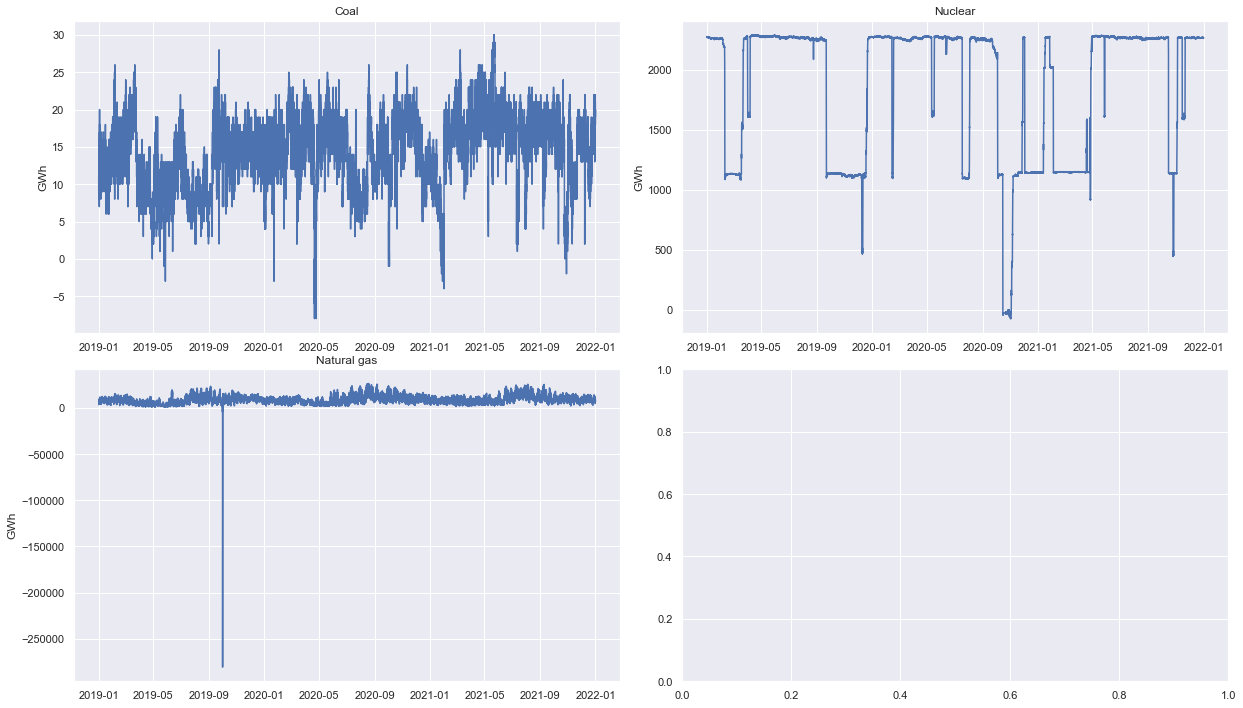

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))
try:
    for i in range(2):
        for j in range(2):
            axs[i, j].plot(sources[non_renewable[2*i+j]])
            axs[i, j].set_title(non_renewable[2*i+j])
            axs[i, j].set_ylabel('GWh')
        fig.tight_layout()
except IndexError:
    plt.show()

## Rolling Mean & Std 

In [23]:
# Rolling mean and std for demand with a window of a day
demands_rolmean = demands['Current demand'].rolling(window=289).mean()
demands_rolstd = demands['Current demand'].rolling(window=289).std()

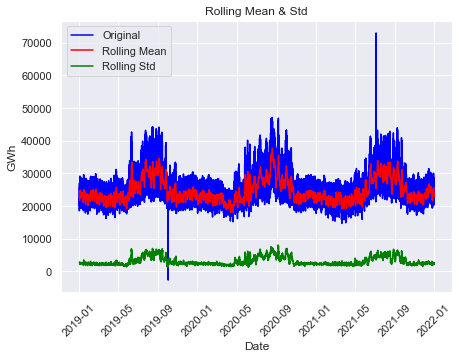

In [24]:
pyplot.title('Rolling Mean & Std')
pyplot.xlabel('Date')
pyplot.ylabel('GWh')
pyplot.plot(demands['Current demand'], color='blue', label='Original')
pyplot.plot(demands_rolmean, color='red', label='Rolling Mean')
pyplot.plot(demands_rolstd, color='green', label='Rolling Std')
pyplot.legend(loc='best')
pyplot.xticks(rotation=45)
pyplot.show()

## Basic Statistics

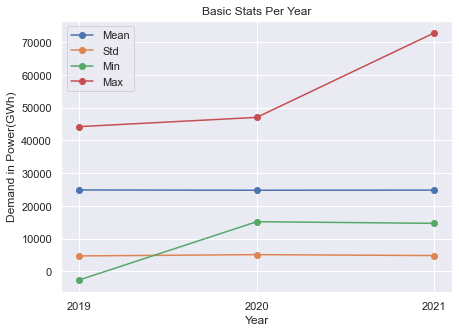

In [25]:
# calc mean, std, min, max per year
means = demands.groupby(by=demands.index.year).mean()['Current demand']
stds = demands.groupby(by=demands.index.year).std()['Current demand']
mins = demands.groupby(by=demands.index.year).min()['Current demand']
maxs = demands.groupby(by=demands.index.year).max()['Current demand']

basic_stats_year = pd.concat([means, stds, mins, maxs], axis=1, keys=['Mean', 'Std', 'Min', 'Max'])
basic_stats_year.plot(xlabel='Year', ylabel='Demand in Power(GWh)', title='Basic Stats Per Year', marker='o')
pyplot.xticks(demands.index.year.unique().values)
pyplot.show()

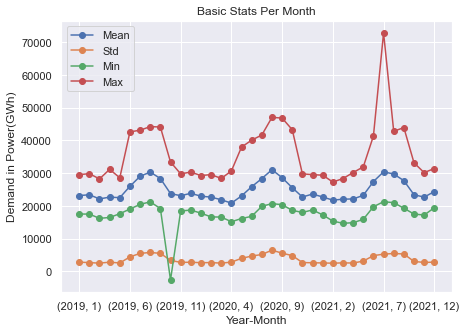

In [26]:
# calc mean, std, min, max per month
means = demands.groupby(by=[demands.index.year, demands.index.month]).mean()['Current demand']
stds = demands.groupby(by=[demands.index.year, demands.index.month]).std()['Current demand']
mins = demands.groupby(by=[demands.index.year, demands.index.month]).min()['Current demand']
maxs = demands.groupby(by=[demands.index.year, demands.index.month]).max()['Current demand']

basic_stats_year_month = pd.concat([means, stds, mins, maxs], axis=1, keys=['Mean', 'Std', 'Min', 'Max'])
basic_stats_year_month.plot(xlabel='Year-Month', ylabel='Demand in Power(GWh)', title='Basic Stats Per Month', marker='o')
pyplot.show()

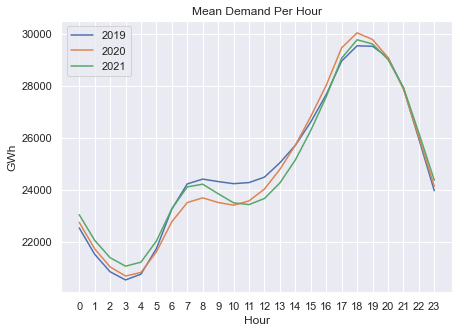

In [27]:
average_hour_per_year = demands.groupby(by=[demands.index.year, demands.index.hour]).mean()
pyplot.title('Mean Demand Per Hour')
pyplot.xlabel('Hour')
pyplot.ylabel('GWh')
pyplot.plot(average_hour_per_year[:24]['Current demand'].values, label='2019')
pyplot.plot(average_hour_per_year[24:48]['Current demand'].values, label='2020')
pyplot.plot(average_hour_per_year[48:]['Current demand'].values, label='2021')
pyplot.legend(loc='best')
pyplot.xticks(demands.index.hour.unique().values)
pyplot.show()

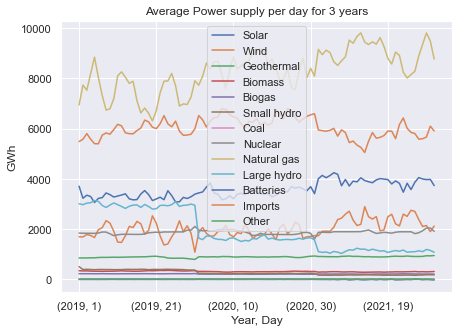

In [28]:
sources_day = sources.groupby(by=[sources.index.year, sources.index.day]).mean()
sources_day.plot(xlabel='Year, Day', ylabel='GWh', title='Average Power supply per day for 3 years')
pyplot.show()

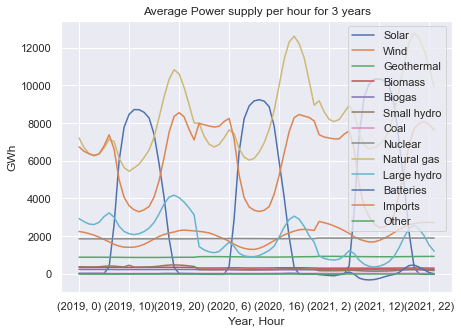

In [29]:
sources_hour = sources.groupby(by=[sources.index.year, sources.index.hour]).mean()
sources_hour.plot(xlabel='Year, Hour', ylabel='GWh', title='Average Power supply per hour for 3 years')
pyplot.show()

## Seasonality Plot

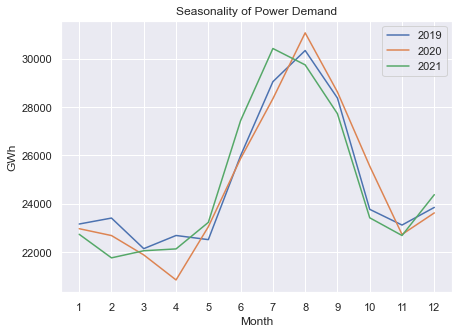

In [30]:
average_month_per_year = demands.groupby(by=[demands.index.year, demands.index.month]).mean()
pyplot.title('Seasonality of Power Demand')
pyplot.xlabel('Month')
pyplot.ylabel('GWh')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[:12]['Current demand'].values, label='2019')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[12:24]['Current demand'].values, label='2020')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[24:]['Current demand'].values, label='2021')
pyplot.xticks(demands.index.month.unique().values)
pyplot.legend(loc='best')
pyplot.show()

## Stationarity Check

In [31]:
### check for stationarity
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

# ADF Test
result = adfuller(demands['Current demand'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(demands['Current demand'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -30.645068252154378
p-value: 0.0
Critial Values:
   1%, -3.430370721762829
Critial Values:
   5%, -2.86154915876347
Critial Values:
   10%, -2.5667748748772925

KPSS Statistic: 2.341517
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


# Data clustering

## Data preparation

In [32]:
# Each row is now a time series
demands_analysis = pd.DataFrame(demands['Current demand'])
demands_analysis['Time'] = demands.index.time
demands_analysis.index = demands_analysis.index.date
demands_analysis = demands_analysis.pivot_table('Current demand', [demands_analysis.index], 'Time')

In [33]:
demands_analysis.head()

Time,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,00:35:00,00:40:00,00:45:00,...,23:10:00,23:15:00,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00,23:55:00
2019-01-01,22216.0,22106.0,22130.0,22040.0,21963.0,21867.0,21792.0,21731.0,21666.0,21624.0,...,22790.0,22647.0,22562.0,22413.0,22302.0,22189.0,22096.0,21961.0,21838.0,21716.0
2019-01-02,21602.0,21521.0,21515.0,21452.0,21337.0,21264.0,21161.0,21100.0,21041.0,20969.0,...,24461.0,24306.0,24139.0,23994.0,23861.0,23731.0,23612.0,23452.0,23353.0,23199.0
2019-01-03,23047.0,22984.0,22945.0,22809.0,22720.0,22652.0,22532.0,22414.0,22320.0,22285.0,...,24138.0,23974.0,23838.0,23707.0,23490.0,23362.0,23257.0,23129.0,23030.0,22910.0
2019-01-04,22806.0,22723.0,22727.0,22681.0,22619.0,22542.0,22431.0,22297.0,22211.0,22158.0,...,23653.0,23518.0,23403.0,23291.0,23161.0,23006.0,22883.0,22751.0,22619.0,22532.0
2019-01-05,22369.0,22271.0,22319.0,22242.0,22151.0,22070.0,21983.0,21883.0,21790.0,21680.0,...,22906.0,22762.0,22632.0,22538.0,22425.0,22322.0,22195.0,22096.0,21973.0,21841.0


In [34]:
sources_analysis = pd.DataFrame(sources.sum(axis=1), columns=['Supply'])
sources_analysis['Time'] = sources.index.time
sources_analysis.index = sources.index.date
sources_analysis
sources_analysis = sources_analysis.pivot_table('Supply', [sources_analysis.index], 'Time')
sources_analysis.head()

Time,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,00:35:00,00:40:00,00:45:00,...,23:10:00,23:15:00,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00,23:55:00
2019-01-01,22402.000000,22344.00000,22289.000000,22213.00000,22186.000000,22048.000000,21999.000000,21920.000000,21831.000000,21851.000000,...,22888.000000,22741.000000,22604.000000,22463.000000,22396.000000,22251.000000,22175.00000,22032.000000,21905.00000,21818.000000
2019-01-02,21758.418685,21733.83737,21706.256055,21649.67474,21553.093426,21539.512111,21492.930796,21445.349481,21388.768166,21309.186851,...,23968.813149,23956.231834,23881.650519,23788.069204,23737.487889,23684.906574,23663.32526,23576.743945,23505.16263,23328.581315
2019-01-03,23145.000000,23153.00000,23029.000000,22944.00000,22911.000000,22809.000000,22697.000000,22544.000000,22467.000000,22433.000000,...,24389.000000,24249.000000,24025.000000,23954.000000,23790.000000,23611.000000,23500.00000,23376.000000,23109.00000,23030.000000
2019-01-04,22907.000000,22885.00000,22789.000000,22795.00000,22739.000000,22638.000000,22535.000000,22373.000000,22308.000000,22264.000000,...,23796.000000,23642.000000,23469.000000,23383.000000,23248.000000,23120.000000,22988.00000,22853.000000,22707.00000,22621.000000
2019-01-05,22437.000000,22450.00000,22429.000000,22293.00000,22239.000000,22163.000000,22079.000000,21984.000000,21906.000000,21783.000000,...,23035.000000,22870.000000,22739.000000,22647.000000,22516.000000,22442.000000,22288.00000,22203.000000,22091.00000,22280.000000


## Power Demand and Supply of 20 random days

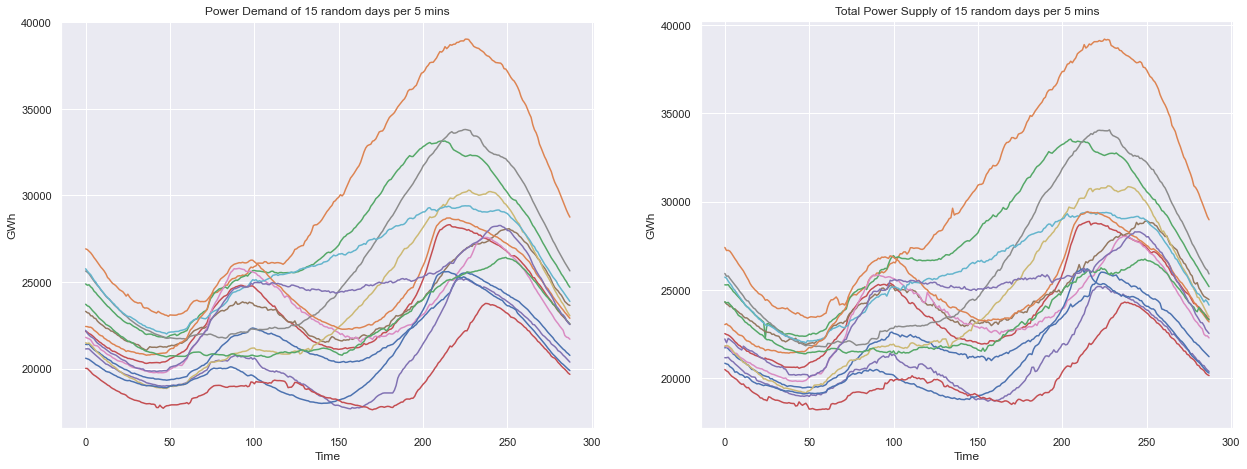

In [35]:
from random import randrange
rands = [randrange(0, demands_analysis.shape[0]) for _ in range(15)]

figs, axs = pyplot.subplots(1, 2, figsize=(21, 7.5))
for j, analysis in enumerate([demands_analysis, sources_analysis]):
    for i in rands:
        axs[j].plot(analysis.iloc[i, :].values)
    axs[j].set_ylabel('GWh')
    axs[j].set_xlabel('Time')
axs[0].set_title('Power Demand of 15 random days per 5 mins')
axs[1].set_title('Total Power Supply of 15 random days per 5 mins')
pyplot.show()

## Standardization Data

In [36]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
demand_matrix = pd.DataFrame(scaler.fit_transform(demands_analysis), columns=demands_analysis.columns)
demand_matrix.index = demands_analysis.index
demand_matrix.head()

Time,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,00:35:00,00:40:00,00:45:00,...,23:10:00,23:15:00,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00,23:55:00
2019-01-01,-0.370054,-0.389920,-0.367174,-0.367775,-0.363610,-0.364247,-0.357731,-0.347755,-0.340706,-0.322904,...,-0.590530,-0.594731,-0.581931,-0.590956,-0.587699,-0.585391,-0.575893,-0.584070,-0.587545,-0.591721
2019-01-02,-0.590835,-0.602579,-0.593053,-0.586228,-0.598762,-0.593291,-0.600093,-0.593023,-0.586492,-0.583495,...,-0.060976,-0.062549,-0.069493,-0.071204,-0.069141,-0.065665,-0.058309,-0.068742,-0.056968,-0.065508
2019-01-03,-0.071245,-0.070751,-0.067838,-0.082076,-0.079249,-0.066073,-0.073503,-0.082274,-0.083516,-0.059927,...,-0.163337,-0.169049,-0.167301,-0.165555,-0.192544,-0.190035,-0.179511,-0.180379,-0.170087,-0.168054
2019-01-04,-0.157904,-0.165630,-0.147906,-0.129630,-0.117189,-0.107855,-0.112297,-0.127752,-0.126381,-0.110453,...,-0.317038,-0.315327,-0.308652,-0.302315,-0.301977,-0.310024,-0.307200,-0.311026,-0.314026,-0.302180
2019-01-05,-0.315039,-0.329940,-0.297758,-0.292728,-0.292990,-0.287140,-0.284370,-0.288673,-0.291942,-0.300625,...,-0.553769,-0.557841,-0.559184,-0.549863,-0.546787,-0.540563,-0.542093,-0.537410,-0.540266,-0.547367


In [37]:
scaler = StandardScaler()
source_matrix = pd.DataFrame(scaler.fit_transform(sources_analysis), columns=sources_analysis.columns)
source_matrix.index = sources_analysis.index
source_matrix.head()

Time,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,00:35:00,00:40:00,00:45:00,...,23:10:00,23:15:00,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00,23:55:00
2019-01-01,-0.451951,-0.461003,-0.464786,-0.463860,-0.444191,-0.460703,-0.445565,-0.446043,-0.451613,-0.411424,...,-0.686602,-0.694655,-0.701991,-0.712117,-0.695719,-0.708518,-0.697111,-0.712254,-0.721255,-0.713212
2019-01-02,-0.687874,-0.687065,-0.683416,-0.677440,-0.686566,-0.657689,-0.643881,-0.634321,-0.629220,-0.631192,...,-0.333441,-0.292612,-0.274487,-0.263083,-0.235659,-0.210488,-0.171880,-0.160346,-0.142110,-0.158601
2019-01-03,-0.179584,-0.161272,-0.187156,-0.186708,-0.166548,-0.165896,-0.172036,-0.198523,-0.196185,-0.175356,...,-0.196143,-0.195754,-0.226522,-0.206853,-0.217650,-0.236157,-0.229518,-0.232068,-0.285493,-0.268226
2019-01-04,-0.266829,-0.260565,-0.277198,-0.243200,-0.232416,-0.232141,-0.235519,-0.266353,-0.260042,-0.243905,...,-0.389909,-0.396572,-0.412560,-0.400351,-0.403528,-0.406693,-0.410203,-0.418926,-0.430988,-0.418390
2019-01-05,-0.439121,-0.421730,-0.412261,-0.433529,-0.423894,-0.416153,-0.414215,-0.420656,-0.421491,-0.439006,...,-0.638569,-0.651977,-0.656820,-0.649764,-0.654565,-0.642179,-0.657233,-0.651159,-0.653936,-0.543589


## Determining the number of clusters based on the Elbow Technique

In [38]:
from sklearn.cluster import KMeans
def find_k(matrix):
    K = range(1, 11)
    distortions = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(matrix)
        distortions += [kmeanModel.inertia_]
    return distortions

### Finding opt K for Demand and Supply

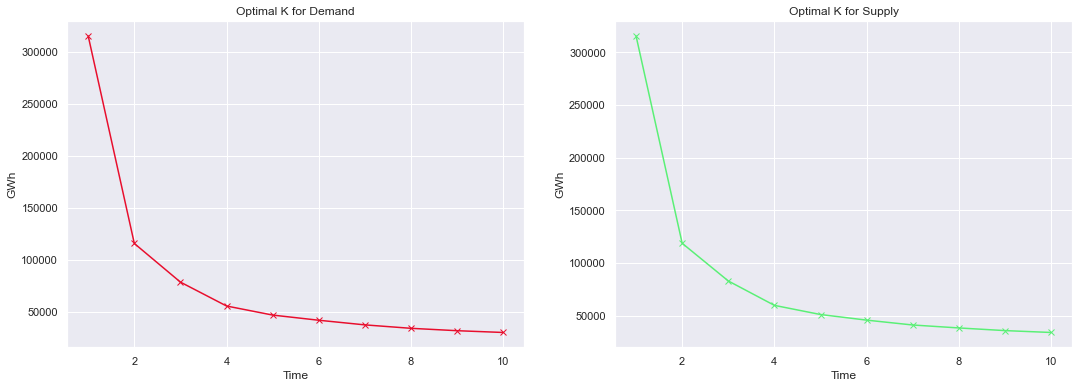

In [39]:
import numpy as np
fig, axs = pyplot.subplots(1, 2, figsize=(18, 6))
K = range(1, 11)
for i, matrix in enumerate([demand_matrix, source_matrix]):
    axs[i].plot(K, find_k(matrix), 'bx-', color=np.random.rand(3,))
    axs[i].set_ylabel('GWh')
    axs[i].set_xlabel('Time')
axs[0].set_title('Optimal K for Demand')
axs[1].set_title('Optimal K for Supply')
pyplot.show()

## Clustering 

In [40]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# cluster object with k = 4 for both datasets
d_cluster = KMeans(n_clusters=4, random_state=217)
s_cluster = KMeans(n_clusters=4, random_state=217)
# apply to demand
demand_matrix['cluster'] = d_cluster.fit_predict(demand_matrix)
# apply to source
source_matrix['cluster'] = s_cluster.fit_predict(source_matrix)
# results
print(demand_matrix['cluster'].value_counts())
print(source_matrix['cluster'].value_counts())

0    500
2    255
1    217
3    124
Name: cluster, dtype: int64
0    489
1    256
2    221
3    130
Name: cluster, dtype: int64


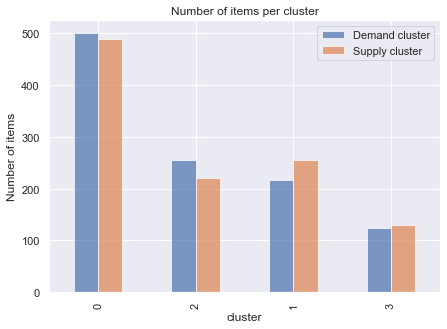

In [41]:
d = pd.DataFrame(demand_matrix['cluster'].value_counts())
d['s_cluster'] = source_matrix['cluster'].value_counts()
ax = d[['cluster', 's_cluster']].plot(kind="bar",  align='center', alpha=0.7)
ax.set_title('Number of items per cluster')
ax.set_xlabel('cluster')
ax.set_ylabel('Number of items')
ax.legend(['Demand cluster', 'Supply cluster'])
pyplot.show()

In [42]:
print(d_cluster.cluster_centers_.shape, s_cluster.cluster_centers_.shape)

(4, 288) (4, 288)


In [43]:
from sklearn.metrics.pairwise import euclidean_distances

demand_distance = euclidean_distances(d_cluster.cluster_centers_, d_cluster.cluster_centers_)
source_distance = euclidean_distances(s_cluster.cluster_centers_, s_cluster.cluster_centers_)
print(demand_distance)
print(125 * '=')
print(source_distance)

[[ 0.         18.57733182 13.97339644 37.41655161]
 [18.57733182  0.         29.62413193 19.59774124]
 [13.97339644 29.62413193  0.         49.19468293]
 [37.41655161 19.59774124 49.19468293  0.        ]]
[[ 0.         13.3679151  17.76304977 37.08293673]
 [13.3679151   0.         28.72638747 48.54089047]
 [17.76304977 28.72638747  0.         19.83615405]
 [37.08293673 48.54089047 19.83615405  0.        ]]


## Visualization Segment

In [44]:
# apply pca for demands
pca = PCA(n_components=3)
x_calls = demand_matrix.columns[:-1]
demand_matrix['x'] = pca.fit_transform(demand_matrix[x_calls])[:,0]
demand_matrix['y'] = pca.fit_transform(demand_matrix[x_calls])[:,1]
demand_matrix['z'] = pca.fit_transform(demand_matrix[x_calls])[:,2]

# apply pca for sources
pca = PCA(n_components=3)
source_matrix['x'] = pca.fit_transform(source_matrix[x_calls])[:,0]
source_matrix['y'] = pca.fit_transform(source_matrix[x_calls])[:,1]
source_matrix['z'] = pca.fit_transform(source_matrix[x_calls])[:,2]

In [45]:
# apply pca for demands
demand_cluster_centers = pca.transform(d_cluster.cluster_centers_)
demand_cluster_centers = pd.DataFrame(demand_cluster_centers, columns=['x', 'y', 'z'])
demand_cluster_centers['cluster'] = range(0, len(demand_cluster_centers))
print(demand_cluster_centers)

# apply pca for sources
source_cluster_centers = pca.transform(s_cluster.cluster_centers_)
source_cluster_centers = pd.DataFrame(source_cluster_centers, columns=['x', 'y', 'z'])
source_cluster_centers['cluster'] = range(0, len(source_cluster_centers))
print(demand_cluster_centers)

           x         y         z  cluster
0  -4.904048 -3.318754  0.364368        0
1  12.702763  2.565594  0.012192        1
2 -16.859919  3.782691 -0.658210        2
3  32.216158  1.113363 -0.136983        3
           x         y         z  cluster
0  -4.904048 -3.318754  0.364368        0
1  12.702763  2.565594  0.012192        1
2 -16.859919  3.782691 -0.658210        2
3  32.216158  1.113363 -0.136983        3


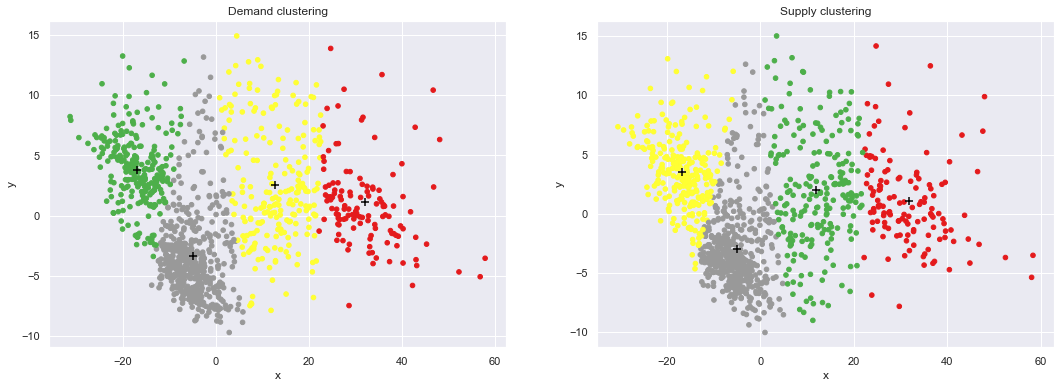

In [46]:
# Plotting for 2-dimention
cluster_centers = [demand_cluster_centers, source_cluster_centers]
fig, axs = pyplot.subplots(1, 2, figsize=(18, 6))
for i, matrix in enumerate([demand_matrix, source_matrix]):
    sc = axs[i].scatter(matrix['x'], matrix['y'], c=matrix['cluster'], s=21, cmap=pyplot.cm.Set1_r)
    axs[i].scatter(cluster_centers[i]['x'], cluster_centers[i]['y'], s=70, c='black', marker='+')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
axs[0].set_title('Demand clustering')
axs[1].set_title('Supply clustering')
# pyplot.colorbar(sc, location='left')
pyplot.show()

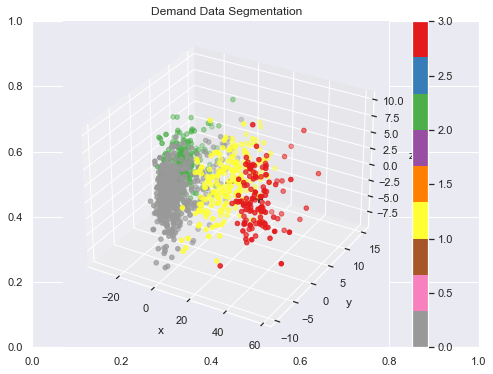

In [47]:
# Plotting for 3-Dimention for demnands
fig, ax = pyplot.subplots(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(demand_matrix['x'], demand_matrix['y'], demand_matrix['z'], c=demand_matrix['cluster'], s=21, cmap=pyplot.cm.Set1_r)
ax.scatter(cluster_centers[0]['x'], cluster_centers[0]['y'], cluster_centers[0]['z'], s=70, c='black', marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
pyplot.colorbar(scatter)
pyplot.title('Demand Data Segmentation')
pyplot.show()

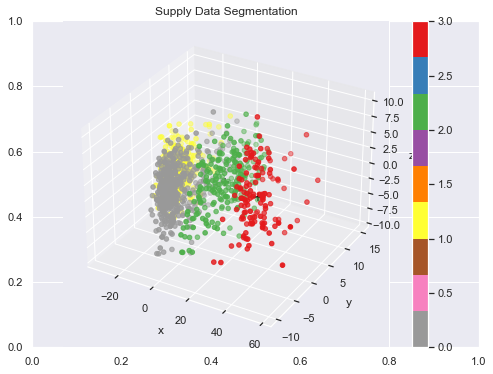

In [48]:
# Plotting for 3-Dimention for demnands
fig, ax = pyplot.subplots(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(source_matrix['x'], source_matrix['y'], source_matrix['z'], c=source_matrix['cluster'], s=21, cmap=pyplot.cm.Set1_r)
ax.scatter(cluster_centers[1]['x'], cluster_centers[1]['y'], cluster_centers[1]['z'], s=70, c='black', marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
pyplot.colorbar(scatter)
pyplot.title('Supply Data Segmentation')
pyplot.show()